In [20]:
import os
import re
import dotenv
import numpy as np
from numpy import inf
import pandas as pd
from pprint import pprint

# library for save and load scikit-learn models
import pickle

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import dtreeviz

In [22]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [3]:
df = pd.read_csv(os.path.join(os.getenv('PROCESSED_DATA_FILES'), 'df_train_test.csv'), encoding='UTF-8')

In [4]:
X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
X = X.set_index('post_id')
X = pd.concat([X.drop(columns=['Keywords']), X['Keywords'].str.get_dummies(sep=",")], axis=1)
X = pd.concat([X.drop(columns=['Dominant_Topic']), X['Dominant_Topic'].astype(str).str.get_dummies()], axis=1)
#X = pd.concat([df_ready.drop(columns=['Keywords']), df_ready['Keywords'].str.get_dummies(sep=",")], axis=1)
#X = pd.concat([df_ready.drop(columns=['Dominant_Topic']), df_ready['Dominant_Topic'].str.get_dummies()], axis=1)
y = df.loc[:, ["post_id", "log_all_engrate"]]
y = y.set_index('post_id')
y = y.squeeze()
print(X.head())
print(y.head())

                                                    log_init_imps  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       8.836810   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...      10.852304   
149644004573512a361a5d89ab8c9003080a3af20fca364...       9.495219   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       8.348538   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       7.942007   

                                                    log_init_engs  approach  \
post_id                                                                       
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       5.420535         0   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...       8.478660         0   
149644004573512a361a5d89ab8c9003080a3af20fca364...       5.988961         0   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       6.570883         0   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.class_weight.values.tolist())

In [8]:
# fit the regressor
reg = tree.DecisionTreeRegressor(random_state=42)

In [9]:
scorer = make_scorer(r2_score)
param_grid = {
    'max_depth': [4, 6, 8, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be a leaf node
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring=scorer, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Find the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [12]:
print(best_params)

{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10}


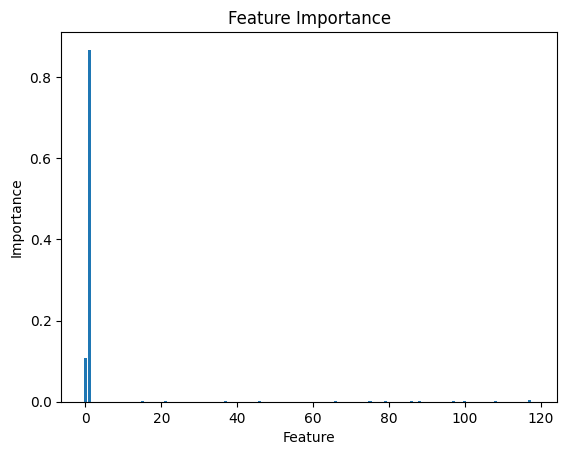

In [19]:
importances = best_model.feature_importances_
features = range(len(importances))
plt.bar(features, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [10]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.82
Test R-squared: 0.74


In [13]:
# scale the predictions back to normal and recalculate R Score
# scale back true values (y)
y_test_normal = np.exp(y_test)
y_train_normal = np.exp(y_train)

# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# scale back predictions
y_train_pred_normal = np.exp(y_train_pred)
y_test_pred_normal = np.exp(y_test_pred)

# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
r_squared_train = r2_score(y_train_normal, y_train_pred_normal)
r_squared_test = r2_score(y_test_normal, y_test_pred_normal)

print(f"Train (normal) R-squared Score: {r_squared_train:.2f}")
print(f"Test (normal) R-squared Score: {r_squared_test:.2f}")

Train (normal) R-squared Score: 0.86
Test (normal) R-squared Score: 0.80


In [14]:
# plot the tree
viz_model = dtreeviz.model(
    best_model,
    X_train=X_train,
    y_train=y_train,
    target_name='log_all_engrate',
    feature_names=X_train.columns
)
v = viz_model.view()     # render as SVG into internal object 
v.show()

A:\git_projects\machine-learning-project\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


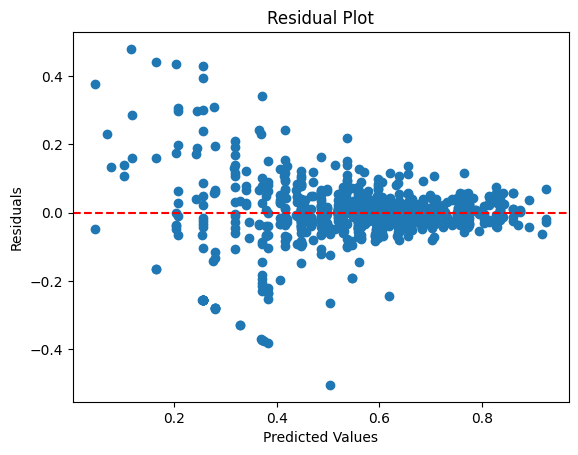

In [17]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

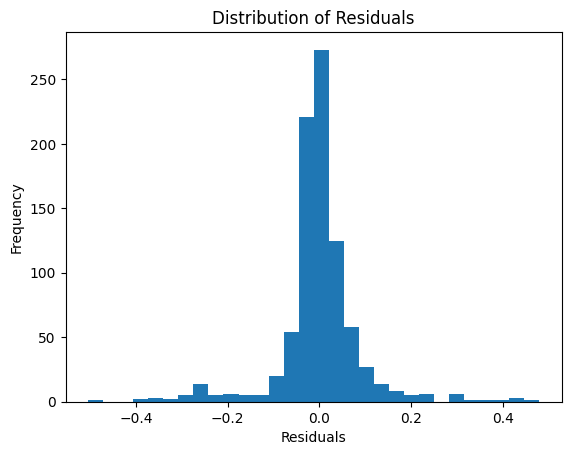

In [18]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

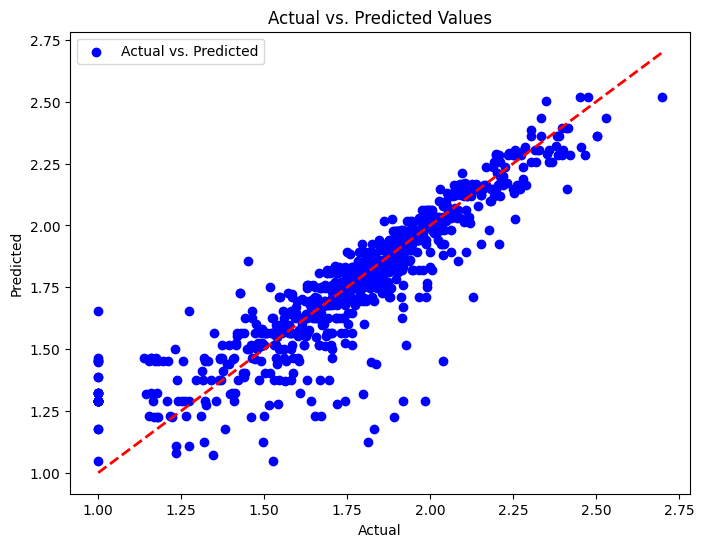

In [16]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_normal, y_test_pred_normal, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test_normal), max(y_test_normal)], [min(y_test_normal), max(y_test_normal)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [24]:
# Save the model
with open(os.path.join(os.getenv('TRAINED_MODELS_PATH'), 'decision_tree_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)